In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# This function reads an image and returns the dimensions and number of channels of the image
def imload(inputImage, RGB = "GRAY"):
    img = cv.imread(inputImage)
    h, w, c = img.shape
    if RGB == "RGB":
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    elif RGB == "GRAY":
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    else:
        img = img

    print("Image loaded: ", inputImage)
    print(f"Height: {h}, width: {w} and channels: {c}")
    
    return img, w, h, c

# This function adjusts the frame of an image so that it fits fully to the frame
def shearingAjdustment(M, x, y):
    # Compute new bounding box
    corners = np.float32([[0, 0], [x, 0], [0, y], [x, y]])
    new_corners = np.dot(M[:, :2], corners.T).T + M[:, 2]

    min_x, min_y = new_corners.min(axis=0)
    max_x, max_y = new_corners.max(axis=0)

    new_w, new_h = int(max_x - min_x), int(max_y - min_y)

    # Adjust transformation to shift image fully into frame
    M[0,2] -= min_x
    M[1,2] -= min_y

    return M, new_w, new_h

<div style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif; font-size: 16px; line-height: 1.8;">
<h3>1. Blurring</h3>

<p>Blurring is a fundamental image processing technique used to reduce noise or sharpness to make an image appear smoother. This is achieved by apply a low-pass filter over the image reducing high frequency noise, by averaging the pixel values in a neighbourhood of a pixel.</p>

<p>There are three common blurring techniques:

- <b>Gaussian filter:</b> Applies a Gaussian kernel (bell-shaped curve) to compute weighted averages. Center pixels have higher weight than distant ones. The Python function takes three parameters, i.e., the input image, kernel (neighbourhood) size $(x, y)$ where $x$ and $y$ are odd numbers, and the standard deviation $\sigma$.

- <b>Median filter:</b> A non-linear filter that replaces each pixel with the median of its neighbouring pixels.This technique is excellent for salt-and-pepper (black and white) noise. It preserves edges better than the Gaussian filter. The Python function takes two parameters, i.e., the input image, kernel size $(x)$ where $x$ is an odd number.

- <b>Bilateral filter:</b> An edge preserving technique, that employs the weighted average on both the proximity (spatial closeness) and intensity (intesity similarity preserves edges) of pixel values. The Python function takes four parameters, i.e., the input image, diameter of pixel neighbourhood, value colours considered similar (large number = more colors) and influence from distant pixels (large number = distant pixels).
</p>

</div>

In [4]:
img, x, y, c = imload("parrots.png", "RGB")

Image loaded:  parrots.png
Height: 491, width: 491 and channels: 3


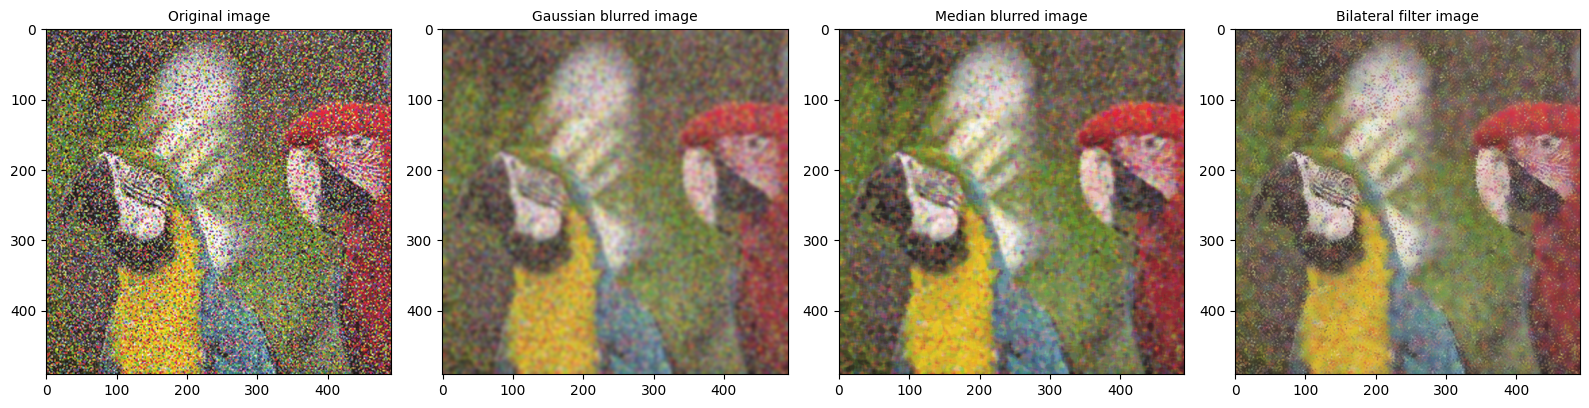

In [5]:
# Applying blurring techniques and plotting
imgGaussian = cv.GaussianBlur(img, (15, 15), 0)
imgMedian = cv.medianBlur(img, 7)
imgBilateral = cv.bilateralFilter(img, 15, 150, 140)

fig, axs = plt.subplots(1, 4, figsize = (16,4))
axs[0].imshow(img), axs[0].set_title("Original image", fontsize=10)
axs[1].imshow(imgGaussian), axs[1].set_title("Gaussian blurred image", fontsize=10)
axs[2].imshow(imgMedian), axs[2].set_title("Median blurred image", fontsize=10)
axs[3].imshow(imgBilateral), axs[3].set_title("Bilateral filter image", fontsize=10)
# for ax in axs:
#     ax.set_xticks([]), ax.set_yticks([])

plt.tight_layout()
plt.show()

<div style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif; font-size: 16px; line-height: 1.8;">

<p>
Below is a comparison table for the filters described above:

| Filter Type | Edge Preservation | Noise Removal | Speed    | Best For            |
|-------------|-------------------|---------------|----------|---------------------|
| Gaussian    | ❌ Moderate       | ✅ Good       | 🚀 Fast  | General blurring    |
| Median      | ✅ Strong         | ✅ Excellent  | 🐢 Slow  | Impulse noise       |
| Bilateral   | ✅ Excellent      | ✅ Good       | 🐢 Slowest | Edge-aware tasks   |

</p>
</div>

<div style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif; font-size: 16px; line-height: 1.8;">
<h3>2. Gray scaling</h3>

<p>Blurring is a fundamental image processing technique used to reduce noise or sharpness to make an image appear smoother. This is achieved by apply a low-pass filter over the image reducing high frequency noise, by averaging the pixel values in a neighbourhood of a pixel.</p>

Image loaded:  road.jpg
Height: 735, width: 1100 and channels: 3


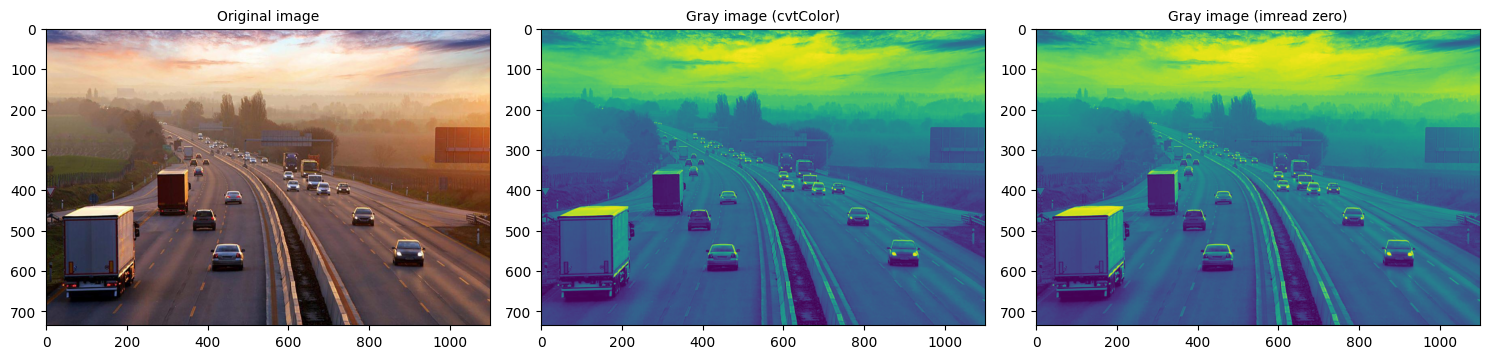

In [6]:
img, x, y, c = imload("road.jpg", "RGB")
imgCVGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
imgGray = cv.imread("road.jpg", 0)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(img), axs[0].set_title("Original image", fontsize = 10)
axs[1].imshow(imgCVGray), axs[1].set_title("Gray image (cvtColor)", fontsize = 10)
axs[2].imshow(imgGray), axs[2].set_title("Gray image (imread zero)", fontsize = 10)
# for ax in axs:
#     ax.set_xticks([]), ax.set_yticks([])

plt.tight_layout()
plt.show()

<div style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif; font-size: 16px; line-height: 1.8;">
<h3>3. Affine transformations</h3>
</div>

<div style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif; font-size: 16px; line-height: 1.8;">

The general form of the affine transformation matrix is:

$$
M = 
\begin{bmatrix}
a & b & t_x \\
c & d & t_y 
\end{bmatrix}
$$
Where:

$a, b, c, d$ --> Control rotation, scaling, and shearing.
$t_x, t_y$ --> Control translation (shift in $X$ and $Y$ directions).

- <b>Translation</b> $(t_x, t_y)$ shifts the image $t_x$ pixels horizontally and $t_y$ pixels vertically
- <b>Scaling</b> $(a, d)$ resizes the image $a$ pixels horizontally and $b$ pixels vertically
- <b>Rotation</b> $(a, b, c, d)$ where $a = \cos\theta$, $b = -\sin\theta$, $c = \sin\theta$ and $d = \cos\theta$ rotates the image by an angle $\theta$
- <b>Shearing (Skewing)</b> $(b, c)$ tilts the image along $X$ or $Y$ axis, also referred to as $X$-shearing ($sh_x$) and $Y$-shearing ($sh_y$), respectively.

</div>

In [30]:
img, x, y, c = imload("mandela-home.jpg", "RGB")

Image loaded:  mandela-home.jpg
Height: 435, width: 360 and channels: 3


<div style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif; font-size: 16px; line-height: 1.8;">
<h4> 3.1 Translation</h4>

<p>Image translation is a geometric transformation that shifts an image in the X and/or Y direction (rectilinear shift of an image from one location to another). It moves every pixel of the image by a specified number of pixels horizontally and vertically. This is useful for tasks like data augmentation, image alignment, or creating panning effects.</p>

</div>

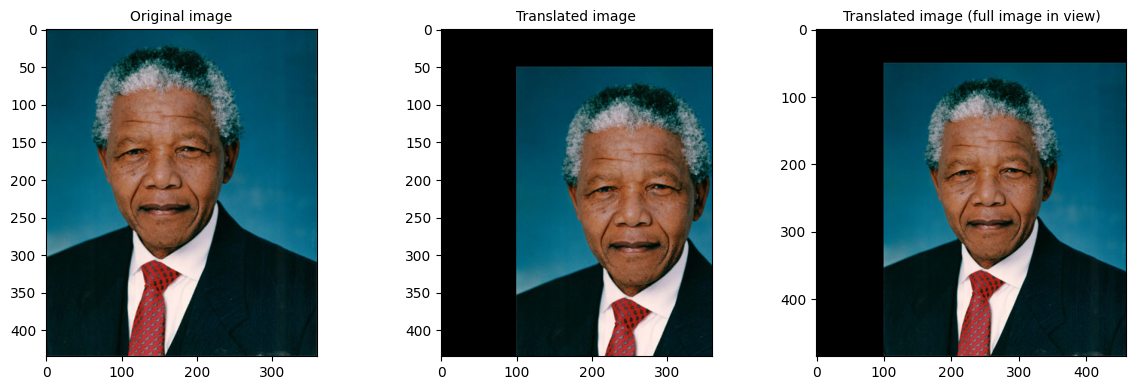

In [36]:
M = np.float32([[1, 0, 100],[0, 1, 50]])
imgTrans = cv.warpAffine(img, M, (x, y))

xNew = int(x + M[0,2])  # extend the x dimension by tx
yNew = int(y + M[1,2])   # extend the y dimension by ty
imgTransFull = cv.warpAffine(img, M, (xNew, yNew))

fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].imshow(img), axs[0].set_title("Original image", fontsize = 10)
axs[1].imshow(imgTrans), axs[1].set_title("Translated image", fontsize = 10)
axs[2].imshow(imgTransFull), axs[2].set_title("Translated image (full image in view)", fontsize = 10)
# for ax in axs:
#     ax.set_xticks([]), ax.set_yticks([])

plt.tight_layout()
plt.show()

# cv.waitKey(0)
# cv.destroyAllWindows()

<div style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif; font-size: 16px; line-height: 1.8;">
In the code above:

A $2 \times 3$ affine transformation matrix of type float32 is defined. The matrix is structured as:
$$
\begin{bmatrix}
1 & 0 & t_x \\
0 & 1 & t_y 
\end{bmatrix}
$$
where $t_x = 100$ and $t_y = 50$.
</p>

<div style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif; font-size: 16px; line-height: 1.8;">

<h4> 3.2 Rotation</h4>

<p>Image rotation is a geometric transformation that turns an image around a specified point (called the rotation center) by a given angle. This is useful for tasks like data augmentation (generate rotated versions of training images), image alignment, document alignment (correct skewed scanned documents) and correcting orientation/object detection preprocessing (handle rotated objects).</p>

<p>
The rotation transformed is achived by defining the rotation matrix listing rotation point, degree of rotation and the scaling factor:

$$
\begin{bmatrix}
\alpha & \beta & (1−\alpha) \cdot center_x − \beta \cdot center_y\\
-\beta & \alpha &   \beta \cdot center_x + (1−\alpha) \cdot center_y
\end{bmatrix}
$$

where $\alpha = \mathrm{scale}\cdot\cos\theta$ and $\beta = \mathrm{scale}\cdot\sin\theta$

The functions used are as follows:

- <b>cv2.getRotationMatrix2D()</b> : takes the rotation point, degree and scaling factor as parameters. It generates a $2 \times 3$ affine transformation matrix for rotation.  A positive angle rotates the image counter-clockwise, a negative angle rotates it clockwise. The scale factor adjusts the image size. A factor of 1.0 means no scaling
- <b>cv2.warpAffine()</b> : applies the rotation transformation.
</p>
</div>

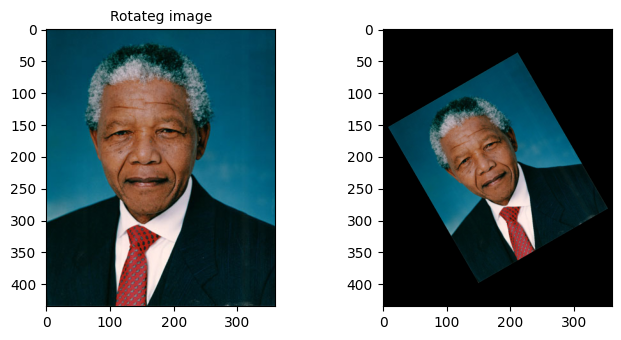

In [32]:
imgRotation = cv.warpAffine(img, cv.getRotationMatrix2D((x/2, y/2), 30, 0.65), (x, y))
fig, axs = plt.subplots(1, 2, figsize = (7,3.5))
axs[0].imshow(img), axs[0].set_title("Original image", fontsize = 10)
axs[1].imshow(imgRotation), axs[0].set_title("Rotateg image", fontsize = 10)
# for ax in axs:
#     ax.set_xticks([]), ax.set_yticks([])
plt.tight_layout()
plt.show()
# cv.imshow('img', img_rotation)
# cv.waitKey(0)
# cv.destroyAllWindows()

<div style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif; font-size: 16px; line-height: 1.8;">
In the code above the parameters:

- $(\frac{x}{2}, \frac{y}{2})$ --> Center of rotation (here, the image center).
- $30$ --> Rotation angle (degrees)
- $0.65$ --> Scaling factor (resizes the image).
</div>

<h4>3.3 Cropping</h4>

In [ ]:
cropped_img = img[100:300, 100:300]
cv.imshow('img', cropped_img)
cv.waitKey(0)
cv.destroyAllWindows()

<div style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif; font-size: 16px; line-height: 1.8;">
<h4>3.4 Shearing</h4>

<p>Shearing (or skewing) is a geometric transformation that tilts an image along the X-axis (horizontal) or Y-axis (vertical). This creates a slanting effect, similar to pushing the top or side of the image while keeping the opposite side fixed.
document correction (fixing skewed scanned documents), data augmentation (generating tilted training images) and computer graphics (creating perspective effects).</p>

<p> Shearing an image can result in the image extending beyond the original image boundaries. If the original image size for display is used, parts of the transformed image get cut off. To compensate for this, the frame of the image must be adjusted as follows:

- Extract the corners (coordinates) of the original frame $(0,0),(x, 0),(0,y),(x,y)$
- Apply the shear transformation matrix $M$ to each corner to determine transformed positions:

$$
\begin{bmatrix}
x'\\
y'  
\end{bmatrix} = M \cdot

\begin{bmatrix}
x \\
y \\
1
\end{bmatrix}
$$

- From these new corners the following are computed:<br>
$\mathrm{min}⁡(x'), \mathrm{max}⁡(x')$ --> leftmost and rightmost extent <br>
$\mathrm{min}⁡(y'),\mathrm{max}⁡(y')$ --> topmost and bottommost extent

- From the minimums and maximums the new width and height are calculated:
$\mathrm{new width}=\mathrm{max}(x')−\mathrm{min}(x'), \mathrm{new height}=\mathrm{max}(y')−\mathrm{min}(y')$

- The transformation matrix is adjusted with translation: Since shear can push parts of the image into negative coordinates, you also need to shift (translate) the result so it fits inside the positive coordinate space of the new window.

<i>NB: The user defined function shearingAjdustment applies this transformation (all the steps above).</i>
</p>

</div>

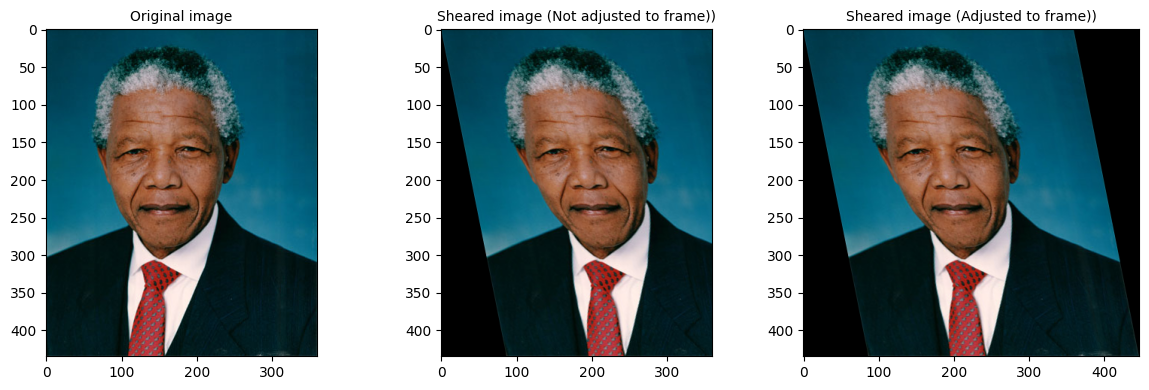

In [42]:
shear_x = 0.2
shear_y = 0
M_shear = np.float32([[1,shear_x,0],[shear_y, 1, 0]])
imgShearNoAdj = cv.warpAffine(img, M_shear,(x, y))

# The adjustment is done using a user defined function shearingAjdustment
mShearNew, xNew, yNew = shearingAjdustment(M_shear, x, y)
imgShearAdj = cv.warpAffine(img, mShearNew,(xNew, yNew))

fig, axs = plt.subplots(1,3, figsize = (12, 4))
axs[0].imshow(img), axs[0].set_title("Original image", fontsize = 10)
axs[1].imshow(imgShearNoAdj), axs[1].set_title("Sheared image (Not adjusted to frame))", fontsize = 10)
axs[2].imshow(imgShearAdj), axs[2].set_title("Sheared image (Adjusted to frame))", fontsize = 10)

# for ax in axs:
#     ax.set_xticks([]), ax.set_yticks([])
plt.tight_layout()
plt.show()

# cv.imshow('img', sheared_img)
# cv.waitKey(0)
# cv.destroyAllWindows()

<div style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif; font-size: 16px; line-height: 1.8;">
<h3>4 Normalisation</h3>

<p>Shearing (or skewing) is a geometric transformation that tilts an image along the X-axis (horizontal) or Y-axis (vertical). This creates a slanting effect, similar to pushing the top or side of the image while keeping the opposite side fixed.
document correction (fixing skewed scanned documents), data augmentation (generating tilted training images) and computer graphics (creating perspective effects).</p>

</div>

Image loaded:  city.jpg
Height: 2000, width: 3000 and channels: 3


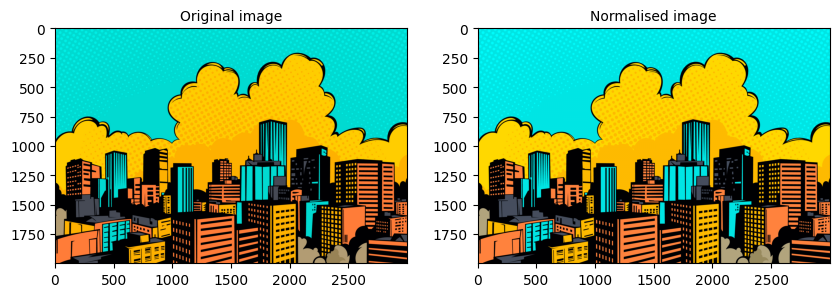

In [5]:
img, x, y, c = imload("city.jpg", "RGB")
b, g, r = cv.split(img)

b_normalization = cv.normalize(b.astype(float), None, 0, 1, cv.NORM_MINMAX)
g_normalization = cv.normalize(g.astype(float), None, 0, 1, cv.NORM_MINMAX)
r_normalization = cv.normalize(r.astype(float), None, 0, 1, cv.NORM_MINMAX)

img_normalized = cv.merge((b_normalization, g_normalization, r_normalization))

fig, axs = plt.subplots(1, 2, figsize = (10, 4.9))
axs[0].imshow(img), axs[0].set_title("Original image", fontsize = 10)
axs[1].imshow(img_normalized), axs[1].set_title("Normalised image", fontsize = 10)
# for ax in axs:
    # ax.set_xticks([]), ax.set_yticks([])
plt.tight_layout
plt.show()

<div style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif; font-size: 16px; line-height: 1.8;">
<h3>5 Edge detection</h3>

<p>Shearing (or skewing) is a geometric transformation that tilts an image along the X-axis (horizontal) or Y-axis (vertical). This creates a slanting effect, similar to pushing the top or side of the image while keeping the opposite side fixed.
document correction (fixing skewed scanned documents), data augmentation (generating tilted training images) and computer graphics (creating perspective effects).</p>

</div>

Image loaded:  city.jpg
Height: 2000, width: 3000 and channels: 3


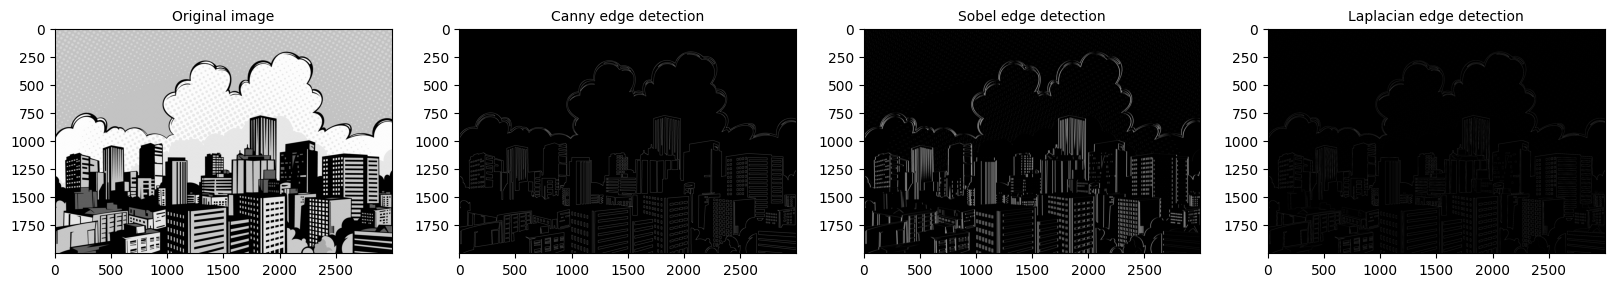

In [37]:
img, x, y, c = imload("city.jpg", "GRAY")

imgCanny = cv.Canny(img, 700, 100)

# Sobel in X direction (vertical edges)
sobelx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=11)

# Sobel in Y direction (horizontal edges)
sobely = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)

# Magnitude of gradient
imgSobel = cv.magnitude(sobelx, sobely)


imgLaplacian = np.abs(cv.Laplacian(img, cv.CV_64F))

fig, axs = plt.subplots(1, 4, figsize = (20, 6))
axs[0].imshow(img, cmap='gray'), axs[0].set_title("Original image", fontsize = 10)
axs[1].imshow(imgCanny, cmap='gray'), axs[1].set_title("Canny edge detection", fontsize = 10)
axs[2].imshow(imgSobel, cmap='gray'), axs[2].set_title("Sobel edge detection", fontsize = 10)
axs[3].imshow(imgLaplacian, cmap='gray'), axs[3].set_title("Laplacian edge detection", fontsize = 10)
# for ax in axs:
#     ax.set_xticks([]), ax.set_yticks([])
plt.tight_layout
plt.show()